In [24]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

sys.path.append('./library')
sys.path.append('../common')

In [ ]:
import pickle
import pandas as pd
import numpy as np
from item_based import ItemBasedRecommender
from metrics import TestMetricsCalculator, RmseCalculator
from tune_k_item_based import tune_k
from rating import get_explicit_rating, get_implicit_rating_out_of_positive_ratings_df, split_matrix_csr, \
    sanity_check_implicit_rating, sanity_check_explicit_split, sanity_check_explicit_matrix


### Load Netflix Dataset

In [4]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Convert `Date` to Unix Timestamp


In [5]:
# Load Movielens dataset

netflix_file_path = "../../eda/dataset_samples/sampled_netflix.parquet"
netflix_df = pd.read_parquet(netflix_file_path)
netflix_df.head()


,movie_id,user_id,Rating,Date,YearMonth
0,11748,1225150,1,2005-12-02,2005-12
1,16339,818050,1,2005-02-16,2005-02
2,17149,85701,1,2004-07-27,2004-07
3,2734,2213353,1,2004-09-29,2004-09
4,6174,1647667,1,2005-05-25,2005-05


### Convert `Date` to Unix Timestamp


In [6]:
netflix_df["Date"] = pd.to_datetime(netflix_df["Date"]).astype(np.int64) // 10 ** 9
netflix_df

,movie_id,user_id,Rating,Date,YearMonth
0,11748,1225150,1,1133481600,2005-12
1,16339,818050,1,1108512000,2005-02
2,17149,85701,1,1090886400,2004-07
3,2734,2213353,1,1096416000,2004-09
4,6174,1647667,1,1116979200,2005-05
...,...,...,...,...,...
10174,15689,2440061,5,1131840000,2005-11
10175,7553,1069538,5,1127088000,2005-09
10176,5732,1304932,5,1106524800,2005-01
10177,4352,2602500,5,1092873600,2004-08


### Calculating the **explicit rating** for the filtered dataset. 

The output consists of two CSR matrices with identical structure: the first matrix contains **the mean  rating** given by user *u_i* to movie *b_i*, and the second matrix stores **the timestamp of the latest rating** at the same positions. 

Additionally, two utility dictionaries are provided, containing mappings **between IDs and matrix indices** (and vice versa).

In [7]:
explicit_ratings, last_dates, user_mapping, item_mapping = get_explicit_rating(netflix_df, "user_id",
                                                                               "movie_id", "Rating", "Date")

explicit_ratings.toarray(), last_dates.toarray()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1133481600,          0,          0, ...,          0,          0,
                  0],
        [         0, 1108512000,          0, ...,          0,          0,
                  0],
        [         0,          0, 1090886400, ...,          0,          0,
                  0],
        ...,
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0],
        [         0,          0,          0, ...,          0,          0,
                  0]]))

**Sanity check**:
* the amount of filled cells in the sparse matrices (`.nnz`) must be the same as **the number of unique pairs** of users and items
* the amount is **the same**

In [8]:
sanity_check_explicit_matrix(explicit_ratings=explicit_ratings, last_dates=last_dates, review_df=netflix_df,
                             user_field="user_id", item_field="movie_id")

,Source,Calculated metrics,Value
0,Explicit ratings matrix,Non-zero entries,10179
1,Last dates matrix,Non-zero entries,10179
2,Filtered review DataFrame,"Unique (user_id, business_id) pairs",10179


### Train / validation / test split

Define the divisions within the initial matrix (**test / validation / train** according to the documentation of split function)
Split matrix in proportions `0.1, 0.2, 0.7` for **test**, **validation** and **train** set.

In [9]:
DIVISIONS = [0.1, 0.2, 0.7]

In [10]:
test_matrix, validation_matrix, train_matrix = split_matrix_csr(explicit_ratings, last_dates, DIVISIONS)
train_matrix.toarray(), validation_matrix.toarray(), test_matrix.toarray()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### **Sanity check** (verify that the explicit matrix has been correctly split into **train, validation, and test** subsets):
* The total number of interactions (nnz) in the splits matches the original explicit matrix.
* The proportions of data in each split (Train, Validation, Test) **almost** align with the intended ratios.
* No interactions are lost during the split.

In [11]:
sanity_check_explicit_split(train_matrix=train_matrix, validation_matrix=validation_matrix, test_matrix=test_matrix,
                            explicit_matrix=explicit_ratings)

,Split,Number of interactions,Part of factual interactions
0,Train,8096,79.54%
1,Validation,1581,15.53%
2,Test,502,4.93%
3,Explicit total,10179,100.0%
4,Factual total,10179,100%


### Tuning `k` Using the Elbow Method and Validation RMSE

This process finds the optimal number of latent features (`k`) for a collaborative filtering model by analyzing:

- **Validation RMSE**: To find the best performing model.
- **Elbow Method**: To determine the point of diminishing returns in performance.



Starting K tuning for Item-Based Collaborative Filtering...


Testing different K values: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]



Tuning Complete
Best K (lowest validation RMSE): 5


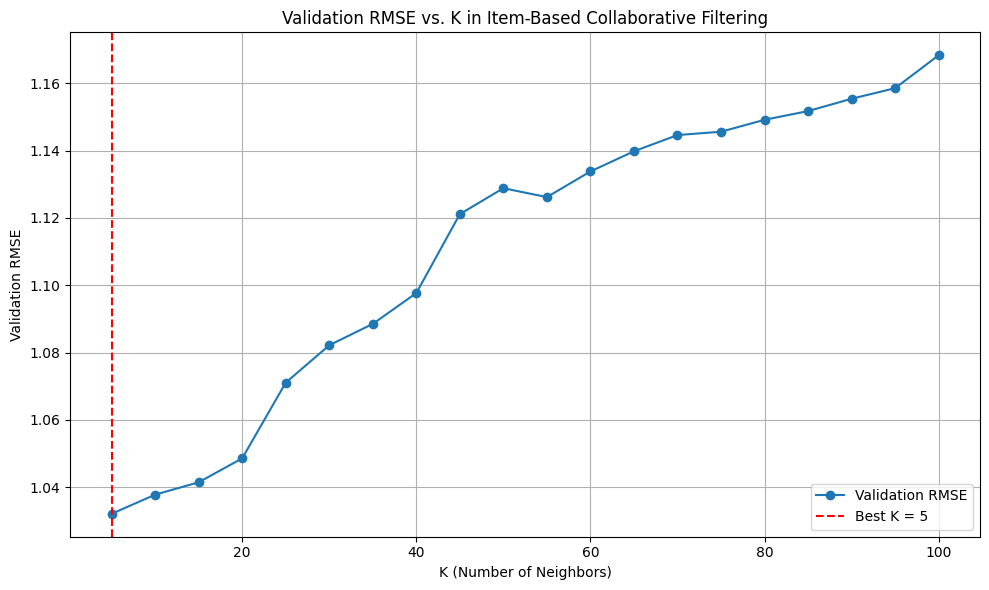

Test RMSE using best K=5: 0.9221
Best K (lowest validation RMSE): 5
Elbow K (stability cutoff):       k  val_rmse
0     5  1.032081
1    10  1.037769
2    15  1.041446
3    20  1.048564
4    25  1.071038
5    30  1.082158
6    35  1.088502
7    40  1.097656
8    45  1.121111
9    50  1.128810
10   55  1.126165
11   60  1.133788
12   65  1.139779
13   70  1.144601
14   75  1.145589
15   80  1.149135
16   85  1.151720
17   90  1.155386
18   95  1.158529
19  100  1.168307


In [12]:
# Tune k using the elbow method and lowest validation RMSE
best_k, elbow_k, results_df, *_ = tune_k(
    train_matrix,
    validation_matrix,
    test_matrix,
    user_mapping=user_mapping,
    item_mapping=item_mapping
)

print(f"Best K (lowest validation RMSE): {best_k}")
print(f"Elbow K (stability cutoff): {elbow_k}")

### Train the Model with Optimal `k`

Once the optimal number of neighbors (`k`) is selected using RMSE and the elbow method, we can train our final item-based recommender model.


In [15]:
# Train the model with optimal k
recommender = ItemBasedRecommender(k=best_k)
recommender.fit(train_matrix, user_mapping, item_mapping)


### Save the Trained Model

After training, it's good practice to serialize the recommender model for later use.


In [16]:
with open("../../models/item_knn_colab_netflix.pkl", "wb") as f:
    pickle.dump(recommender, f)

### Initialize Metrics Calculator for Testing

With the model trained and saved, the next step is to evaluate its performance on the test dataset.


In [17]:
metrics_calculator = TestMetricsCalculator(
    test_matrix=test_matrix,
    model=recommender,
    idx_to_user_id=user_mapping['idx_to_id'],
    idx_to_item_id=item_mapping['idx_to_id']
)

INFO:root:Create top-10 recommendations' list


INFO:root:User: 0 -- top 10 list -- [(2769, 5.0), (2428, 5.0), (2387, 4.0), (2365, 4.0), (2005, 4.0), (1728, 4.0), (1527, 4.0), (830, 4.0), (539, 4.0), (487, 4.0)]
INFO:root:User: 1 -- top 10 list -- [(3356, 5.0), (2988, 5.0), (2890, 5.0), (2732, 5.0), (2448, 5.0), (1895, 5.0), (1745, 5.0), (312, 4.487046532835566), (1910, 3.7900975621122517), (125, 3.612504393364528)]
INFO:root:User: 2 -- top 10 list -- [(3496, 4.0), (3477, 4.0), (2682, 4.0), (2013, 4.0), (949, 4.0), (892, 4.0), (795, 3.160281949403479), (3115, 3.0000000000000004), (2520, 3.0), (2375, 3.0)]
INFO:root:User: 3 -- top 10 list -- [(2886, 4.0), (2126, 4.0), (1274, 4.0), (1098, 4.0), (759, 4.0), (391, 4.0), (9, 3.25), (8, 3.25), (7, 3.25), (6, 3.25)]
INFO:root:User: 4 -- top 10 list -- [(9, 1.0), (8, 1.0), (7, 1.0), (6, 1.0), (5, 1.0), (4, 1.0), (3, 1.0), (2, 1.0), (1, 1.0), (0, 1.0)]
INFO:root:User: 5 -- top 10 list -- [(2516, 5.0), (1600, 5.0), (954, 5.0), (1504, 4.323293544313843), (5, 4.323293544313843), (1448, 4.0), (9

### Evaluate Test Set Performance

Now that the `TestMetricsCalculator` is initialized, we can compute evaluation metrics on the test data.


In [18]:
metrics_calculator.get_test_set_statistic()

Mean popularity                0.000038
Max popularity                 0.001406
Min popularity                 0.000000
Number of pairs         10381405.000000
Non-null pairs (u-i)         502.000000
% of non-null pairs            0.004836
Relevant pairs (u-i)         502.000000
% of relevant pairs            0.004836
dtype: object

### Compute RMSE on the Test Set

Root Mean Squared Error (RMSE) is a widely used metric to evaluate prediction accuracy for recommendation systems.


In [20]:
rmse_calc = RmseCalculator(matrix=test_matrix, model=recommender, idx_to_user_id=user_mapping['idx_to_id'],
                      idx_to_item_id=item_mapping['idx_to_id'])

rmse_calc.calculate_rmse()

np.float64(0.9220935760550254)

### Generate Metrics Summary DataFrame

To consolidate evaluation results, we can generate a summary DataFrame that includes RMSE and other key metrics.


The test dataset is in a cold start state, meaning many items haven't been interacted with before. As a result, most items are irrelevant, and the system struggles to recommend items that are both relevant and serendipitous.

The serendipity score is 0.0, which confirms that while recommendations might be unexpected, they're not actually useful or relevant to users.

Although unexpectedness is high (0.88) and novelty is strong (0.89), meaning the system avoids only recommending popular items, these recommendations often miss the mark in terms of relevance.

The accuracy of the model (RMSE) is 0.92, means the model’s predicted ratings are, on average, less than 1 point away from the actual user ratingsThis is generally considered good accuracy, especially in a cold-start setting, where little information is available for new items or users.

The system shows low inter-user diversity (0.0735), so users are often seeing the same or very similar recommendations.

Item space coverage and catalog coverage are only moderate (21.6 items), suggesting the system doesn't explore a large part of the catalog or generate very unique lists for different users.

However, one positive takeaway is that the system doesn't simply recommend popular items — it introduces lesser-known (unpopular) content, which is a good sign for encouraging discovery.



In [21]:
metrics_calculator.generate_metrics_summary_df(rmse=rmse_calc.calculate_rmse())

There is no one relevant item in the top-10 recommendation list => Recovery can't be calculated


,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,None,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.073533,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.573308,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,21.595,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.891,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.882,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.0,"[0, 1]",Proportion of unexpected and relevant items in...
7,RMSE,Relevance,0.922,"[0, 6]",Root Mean Square Error between predicted and a...


### The meanings of the metrics and their ranges

In [23]:
metrics_calculator.get_range_of_metrics()

,Metric,Min,Max,Explanation
0,Item space coverage,0,Not defined,small - recommendations focuses on several ite...
1,Recovery,0,0.9,0 - all the relevant items on the top of the l...
2,Normalized AggDiv (diversity),0,1,"0 - only 1 item was recommended for everyone, ..."
3,Normalized AggDiv (coverage),0,1,"0 - only 1 item was recommended, 1 - all the i..."
4,Unexpectedness (with_relevance=False),0,1,0 - there is no unexpected item (popularity be...
5,Serendipity (with_relevance=True),0,1,0 - there is no serendipitous item (popularity...
6,Normalized ItemDeg,0,1,0 - the most popular items are used (no novelt...
